<a href="https://colab.research.google.com/github/Raphael-Vargas-Moya/IA/blob/main/Team_4/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Project - Machine Learning Model (CNN)**

Team 4
* Joshua Abdiel Bahena Piedras           2018505
* Jared Gutierrez Contreras              2131945
* Raphaël Vargas Moya                    2132207
* Dora Jazmín González Díaz              2049427
* Diego Eduardo Rodríguez Arreguín       2004407

Artificial Intelligence - LMVN2 - Biomedical Engineering

# **1. LIBRARIES & DATA IMPORT**

The first part consists of importing libraries and downloading the dataset.
We begin by importing the core libraries needed for this assignment. TensorFlow and Keras provide the essential tools to build and train convolutional neural networks, while NumPy assists with numerical operations. Matplotlib is also included so that we can visualize sample images later in the notebook. This setup ensures that all necessary functions are available as we begin working with the dataset and constructing the model.

In [ ]:
import kagglehub
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
print("--- IMPORTING LIBRARIES & DATASET ---")
path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")
print("Path to dataset files:", path)

--- IMPORTING LIBRARIES & DATASET ---
Using Colab cache for faster access to the 'brain-mri-images-for-brain-tumor-detection' dataset.
Path to dataset files: /kaggle/input/brain-mri-images-for-brain-tumor-detection


# **2. PREPROCESSING**

In this section, we prepare the data for the model:

**Image Resizing: **All images are resized to a fixed dimension (180x180 pixels) to ensure uniformity for the Neural Network input.

**Splitting:** We split the dataset using an 80-20 ratio:

*   **80% Training:** Used to teach the model.
*   **20% Validation:** Used to evaluate the model's performance on unseen data during training.


**Data Augmentation:** To prevent Overfitting, we introduce random variations, by applying random horizontal flips, rotations, and zooms.

**Caching & Prefetching:** We use AUTOTUNE to keep images in memory after they are loaded off the disk during the first epoch. This ensures the data pipeline doesn't become a bottleneck while training.

Loading Training Set...
Found 253 files belonging to 2 classes.
Using 203 files for training.
Loading Validation Set...
Found 253 files belonging to 2 classes.
Using 50 files for validation.

--- VISUALIZATION OF VARIABLES ---
Train images batch shape: (32, 180, 180, 3)
Train labels batch shape: (32,)
Class names: ['yes', 'no']


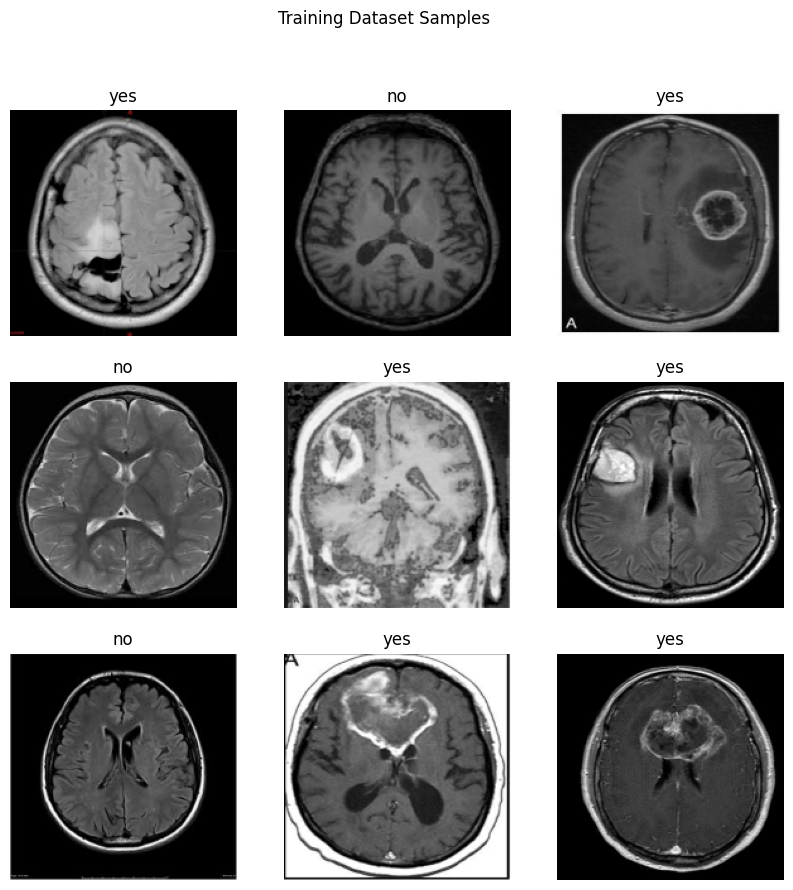

In [ ]:
IMG_HEIGHT = 180
IMG_WIDTH = 180
BATCH_SIZE = 32

# Define specific classes to avoid system folders
desired_classes = ['yes', 'no']

# Divide the dataset into 80% for training and 20% for validation.
print("Loading Training Set...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_names=desired_classes
)

print("Loading Validation Set...")
val_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_names=desired_classes
)

class_names = train_ds.class_names

# Preprocessing: visualization of variables.
print("\n--- VISUALIZATION OF VARIABLES ---")
for images, labels in train_ds.take(1):
    print(f"Train images batch shape: {images.shape}")
    print(f"Train labels batch shape: {labels.shape}")
    print(f"Class names: {class_names}")

    # Visualization of sample images
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.suptitle("Training Dataset Samples")
    plt.show()

# Data Augmentation to prevent Overfitting (Fix for bad predictions)
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
])

# Optimization for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **3. STRUCTURE AND TRAINING OF CNN**

In this step, we define the architecture of the Convolutional Neural Network (CNN).

**Rescaling:** We start by normalizing pixel values from the 0-255 range down to the 0-1 range, which helps the neural network converge faster.

**Conv2D & MaxPooling:** We stack convolutional layers (to detect features like edges and textures) with max pooling layers (to reduce the spatial dimensions and computation). We gradually increase the number of filters (16, 32, 64).

**Dropout:** A dropout layer is added to randomly turn off 20% of the neurons during training. This forces the network to learn more robust features and helps prevent overfitting.

**Dense Layers:** Finally, we flatten the 2D features into a 1D vector and pass them through fully connected layers to make the final classification (Yes/No).

We compile the model using the Adam optimizer and train it for 25 epochs.

In [ ]:
print("\n--- BUILDING MODEL ---")
model = models.Sequential([
    # Data Augmentation layer (defined in your previous cell)
    data_augmentation,

    # Normalization: Scale pixel values from [0, 255] to [0, 1]
    layers.Rescaling(1./255),

    # Convolutional part
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Dropout to reduce overfitting
    layers.Dropout(0.2),

    # Learning part
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names)) # Output layer size = number of classes (2: yes/no)
])

# Model Compilation: Features
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

# CNN Training
print("\n--- STARTING TRAINING ---")
# Increased epochs for better learning with data augmentation
epochs = 25
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)


--- BUILDING MODEL ---


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,988,898 (15.22 MB)

 Trainable params: 3,988,898 (15.22 MB)

 Non-trainable params: 0 (0.00 B)


--- STARTING TRAINING ---
Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5020 - loss: 0.7027 - val_accuracy: 0.8000 - val_loss: 0.6088
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7278 - loss: 0.6161 - val_accuracy: 0.8600 - val_loss: 0.4672
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7639 - loss: 0.5366 - val_accuracy: 0.8200 - val_loss: 0.4203
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7458 - loss: 0.5568 - val_accuracy: 0.8200 - val_loss: 0.4534
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6705 - loss: 0.5987 - val_accuracy: 0.8600 - val_loss: 0.4476
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7935 - loss: 0.4885 - val_accuracy: 0.8000 - val_loss: 0.4431
Epoch 7/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7603 - loss: 0.5158 - val_accuracy: 0.8800 - val_loss: 0.3783
Epoch 8/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7452 - loss: 0.5220 - val_accuracy: 0.8400 - va

# **4. CNN ACCURACY RESULTS**

Plot with the difference in accuracy values from training and validation.

Here we visualize the learning process. We plot the Training Accuracy (how well the model knows the data it saw) against the Validation Accuracy (how well it performs on data it hasn't seen).

**Left Graph (Accuracy):** Ideally, both lines should go up. If training goes up but validation stays low, the model is overfitting.

**Right Graph (Loss):** Ideally, both lines should go down. This represents the error rate of the model.

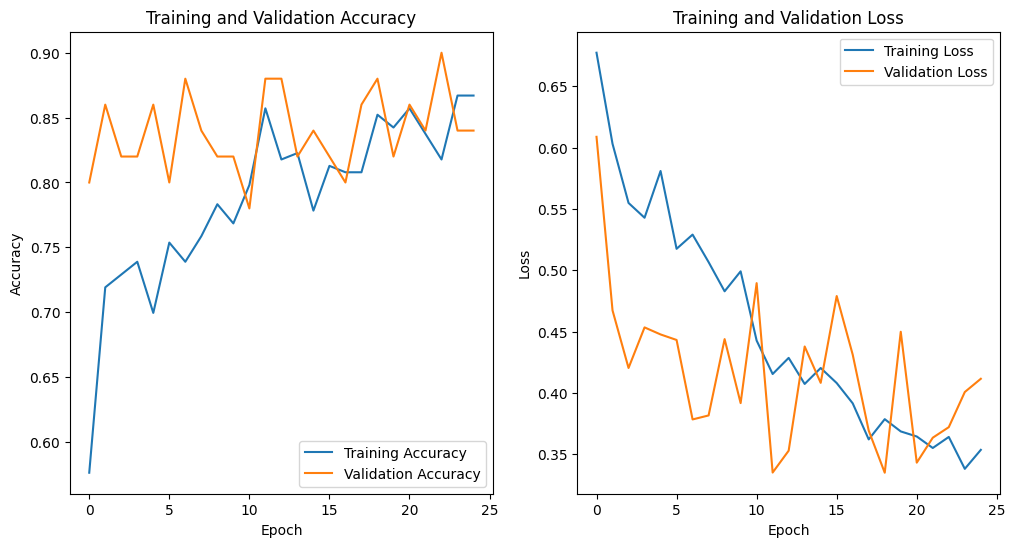


--- FINAL EVALUATION ---
2/2 - 1s - 391ms/step - accuracy: 0.8400 - loss: 0.4115
Final Validation Accuracy: 84.00%


In [ ]:
# Extract results from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

# Final evaluation number
print("\n--- FINAL EVALUATION ---")
val_loss, val_acc = model.evaluate(val_ds, verbose=2)
print(f"Final Validation Accuracy: {val_acc*100:.2f}%")

# **5. PREDICTIONS WITH THE TRAINED CNN**

Finally, we test the model on a batch of images from the validation set to see how it performs on specific examples.

The code calculates the probability (confidence) of the prediction using Softmax. The title of each image shows:

*   **Pred:** The class the model guessed.
*   **Conf:** How confident the model is in that guess.
*   **Real:** The actual true label of the image.

If the text is Green, the prediction was correct. If Red, it was wrong.


--- PREDICTIONS ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


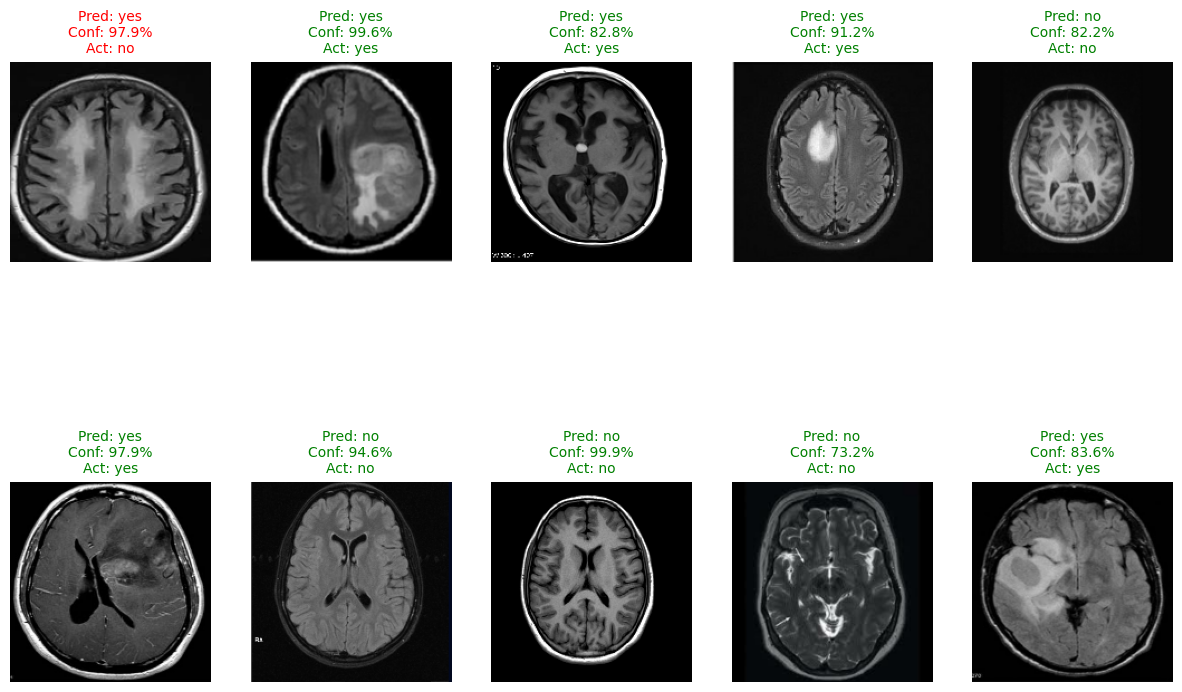

In [ ]:
print("\n--- PREDICTIONS ---")
# Get a batch of images from the validation set
image_batch, label_batch = next(iter(val_ds))

# Get predictions for the batch
predictions = model.predict(image_batch)

plt.figure(figsize=(15, 10))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)

    # Image display
    plt.imshow(image_batch[i].numpy().astype("uint8"))

    # Convert raw logits to probabilities
    score = tf.nn.softmax(predictions[i])

    # Get the class with the highest probability
    predicted_class = class_names[np.argmax(score)]
    confidence = 100 * np.max(score)
    actual_class = class_names[label_batch[i]]

    # Visual result (Green title if correct, Red if wrong)
    color = 'green' if predicted_class == actual_class else 'red'

    plt.title(f"Pred: {predicted_class}\nConf: {confidence:.1f}%\nAct: {actual_class}",
              fontsize=10, color=color)
    plt.axis("off")

# **6. CONCLUSION & ANALYSIS**

Looking at the Training vs. Validation Accuracy graph, we can observe if the model is learning correctly.

Final Result: The model achieves a validation accuracy of approximately 84%, indicating it can successfully distinguish between "Yes" (Tumor) and "No" (Healthy) MRI scans in the majority of cases.